# Herdingspikes Lightning Benchmark

This notebook runs a small benchmark and computes performance metrics.

To run this, install a SpikeInterface version higher than the 0.100 release (best from GitHub [https://github.com/SpikeInterface/spikeinterface](https://github.com/SpikeInterface/spikeinterface)) as it requires the new functionality to generate ground truth data.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.insert(0,"../")
# set the path to spikeinterface source
sys.path.insert(0,"../../spikeinterface/src")
sys.path.insert(0,"../../spikeinterface/spikeinterface/src")
sys.path.insert(0,"../../spikeinterface/probeinterface/src")

import spikeinterface.full as si
import herdingspikes as hs
import numpy as np
from matplotlib import pyplot as plt
si.set_global_job_kwargs(n_jobs=-1, progress_bar=False, chunk_duration="1s")

### Generate a ground truth dataset

This example generates a probe with 32 channels and neuropixels geometry. It then generates a short ground truth dataset with 30 units.

In [2]:
 num_units=30
 rec, rec_drift, gt_sorting = si.generate_drifting_recording(
    num_units=num_units,
    duration=600.,
    sampling_frequency=30000.0,
    generate_probe_kwargs = dict(
        num_columns=4,
        num_contact_per_column=[8] * 4,
        xpitch=16,
        ypitch=40,
        y_shift_per_column=[20, 0, 20, 0],
        contact_shapes="square",
        contact_shape_params={"width": 12},
    ),
    generate_templates_kwargs=dict(
        ms_before=1.5,
        ms_after=3.0,
        mode="ellipsoid",
        unit_params=dict(
            alpha=(150.0, 500.0),
            spatial_decay=(10, 45),
        ),
    ),
    generate_unit_locations_kwargs=dict(
        margin_um=10.0,
        minimum_z=6.0,
        maximum_z=25.0,
        minimum_distance=12.0,
        max_iteration=100,
        distance_strict=False,
    ),    
    generate_sorting_kwargs=dict(
        # firing_rates=(1.0, 4.0),
        firing_rates=(0.1, 1.0),
        refractory_period_ms=4.0
    ),
    generate_noise_kwargs=dict(
        noise_levels=(5.0, 10.0),
        spatial_decay=25.0
    ),
    seed=42
)

# obtain locations and SNR for the ground truth units
gt_analyzer = si.create_sorting_analyzer(gt_sorting, rec, sparse=True)
gt_analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels"])
gt_analyzer.compute(["unit_locations"])
gt_analyzer.compute(
    "quality_metrics",
    metric_names=[
        "snr",
    ],
)

### Parameters


In [3]:
parameters = {
    "chunk_size": None,
    "rescale": True,
    "lowpass": True,
    "rescale_value": -1280.0,
    "common_reference": "median",
    "spike_duration": 1.0,
    "amp_avg_duration": 0.4,
    "threshold": 8.0,
    "min_avg_amp": 1.0,
    "AHP_thr": 0.0,
    "neighbor_radius": 90.0,
    "inner_radius": 70.0,
    "peak_jitter": 0.25,
    "rise_duration": 0.26,
    "decay_filtering": False,
    "decay_ratio": 1.0,
    "localize": True,
    "save_shape": True,
    "out_file": "HS2_detected",
    "left_cutout_time": 0.3,
    "right_cutout_time": 1.8,
    "verbose": False,
    "clustering_bandwidth": 4.0,
    "clustering_alpha": 4.5,
    "clustering_n_jobs": -1,
    "clustering_bin_seeding": True,
    "clustering_min_bin_freq": 4,
    "clustering_subset": None,
    "pca_ncomponents": 2,
    "pca_whiten": True,
}

### Perform spike detection

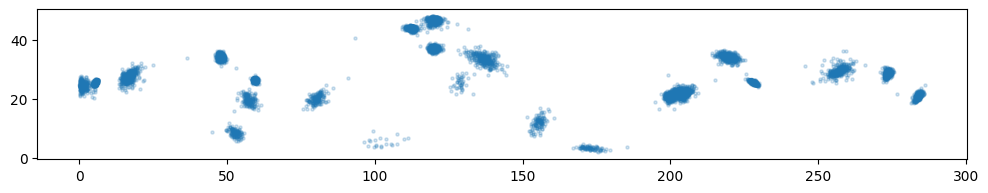

In [4]:
det = hs.HSDetectionLightning(rec, parameters)
det.DetectFromRaw()
plt.figure(figsize=(12,3))
# detL.PlotDensity(binsize=2,  invert=True);
ax = det.PlotAll(invert=True, s=5, alpha=0.2)
ax.set_aspect('equal', 'box')

### Perform clustering and plot the clusters

Reading spikes from detection
Fitting dimensionality reduction using all spikes...
...projecting...
...done
Clustering...
Clustering 7461 spikes...
requested -1 cpus
using 8 cpus
number of seeds: 154
seeds/job: 20


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished


Number of estimated units: 24


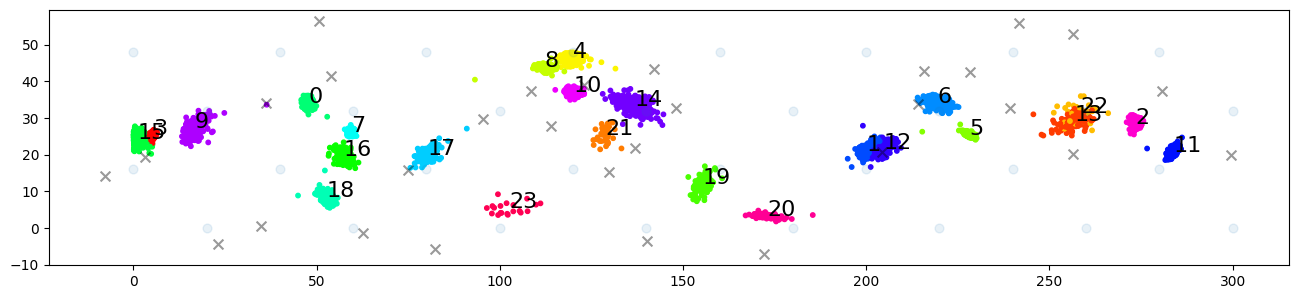

In [5]:
Clusters = hs.HSClustering(det)
Clusters.ShapePCA()
Clusters.CombinedClustering(
    alpha=parameters["clustering_alpha"],
    bandwidth=parameters["clustering_bandwidth"],
    bin_seeding=parameters["clustering_bin_seeding"],
    min_bin_freq=parameters["clustering_min_bin_freq"],
    cluster_subset=parameters["clustering_subset"],
    n_jobs=-1)

# store, this can be read by the HerdingspikesSortingExtractor
Clusters.SaveHDF5("test.hdf5", sampling=rec.get_sampling_frequency())

plt.figure(figsize=(16, 4))
ax = Clusters.PlotAll(invert=True, s=10, show_labels=True)
ax.set_aspect('equal', 'box')
plt.scatter(rec.get_channel_locations()[:,1], rec.get_channel_locations()[:,0], s=40, alpha=.1)
for i in range(num_units):
    x,y,_ = gt_sorting.get_unit_property(i,'gt_unit_locations')
    plt.scatter(y,x, s=50, c='k', marker='x', alpha=0.4)

### Evaluate performance on the ground truth dataset

SUMMARY
-------
GT num_units: 30
TESTED num_units: 24
num_well_detected: 21
num_redundant: 0
num_overmerged: 0
num_false_positive_units 1
num_bad: 1



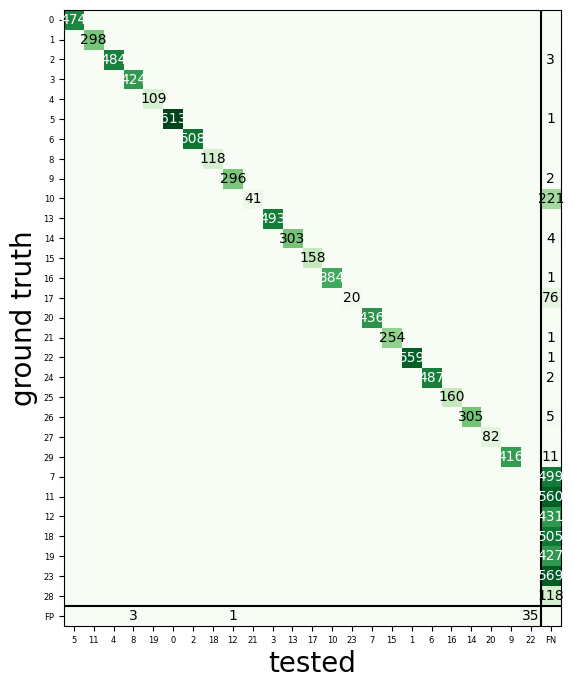

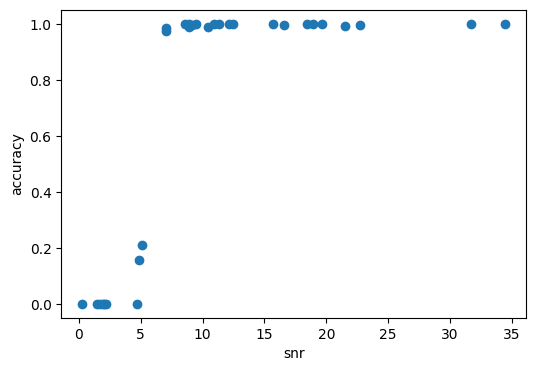

In [6]:
sampling_frequency = rec.get_sampling_frequency()
spike_indexes = np.array(Clusters.spikes.t)
spike_labels = np.array(Clusters.spikes.cl)
sorting = si.NumpySorting.from_times_labels(spike_indexes, spike_labels, sampling_frequency)

comp = si.compare_sorter_to_ground_truth(gt_sorting, sorting, match_score=.1, exhaustive_gt=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.xaxis.label.set_size(8)
si.comparison.ConfusionMatrixWidget(comp, ax=ax)
ax.xaxis.set_tick_params(labelsize=6)
ax.yaxis.set_tick_params(labelsize=6)
comp.print_summary()

fig, ax = plt.subplots(figsize=(6,4))
metrics = gt_analyzer.get_extension("quality_metrics").get_data()
perfs = comp.get_performance()
x = metrics.loc[:, "snr"].values
y = perfs.loc[:, "accuracy"].values
ax.scatter(x, y)
ax.set_ylabel("accuracy")
ax.set_xlabel("snr");

The sorter performs well on this dataset, with a high number of true positives and only one false positive unit. Units with SNR below about 6 are not or only partially detected. This could be improved by lowering the detection threshold, but this would also increase the number of false positives.

### Use built-in functions to inspect units

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]

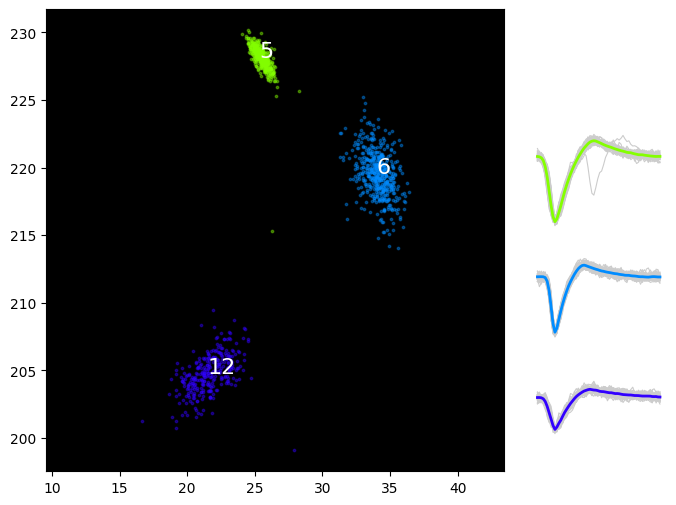

In [7]:
u1 = 0
# loc = np.array(
#     [
#         gt_sorting.get_unit_property(u, "gt_unit_locations")
#         for u in gt_sorting.get_unit_ids()
#     ]
# )
loc =     [
        gt_sorting.get_unit_property(u, "gt_unit_locations")
        for u in gt_sorting.get_unit_ids()
    ]

u2 = comp.agreement_scores.loc[u1].argmax()
Clusters.PlotNeighbourhood(u2, radius=25)

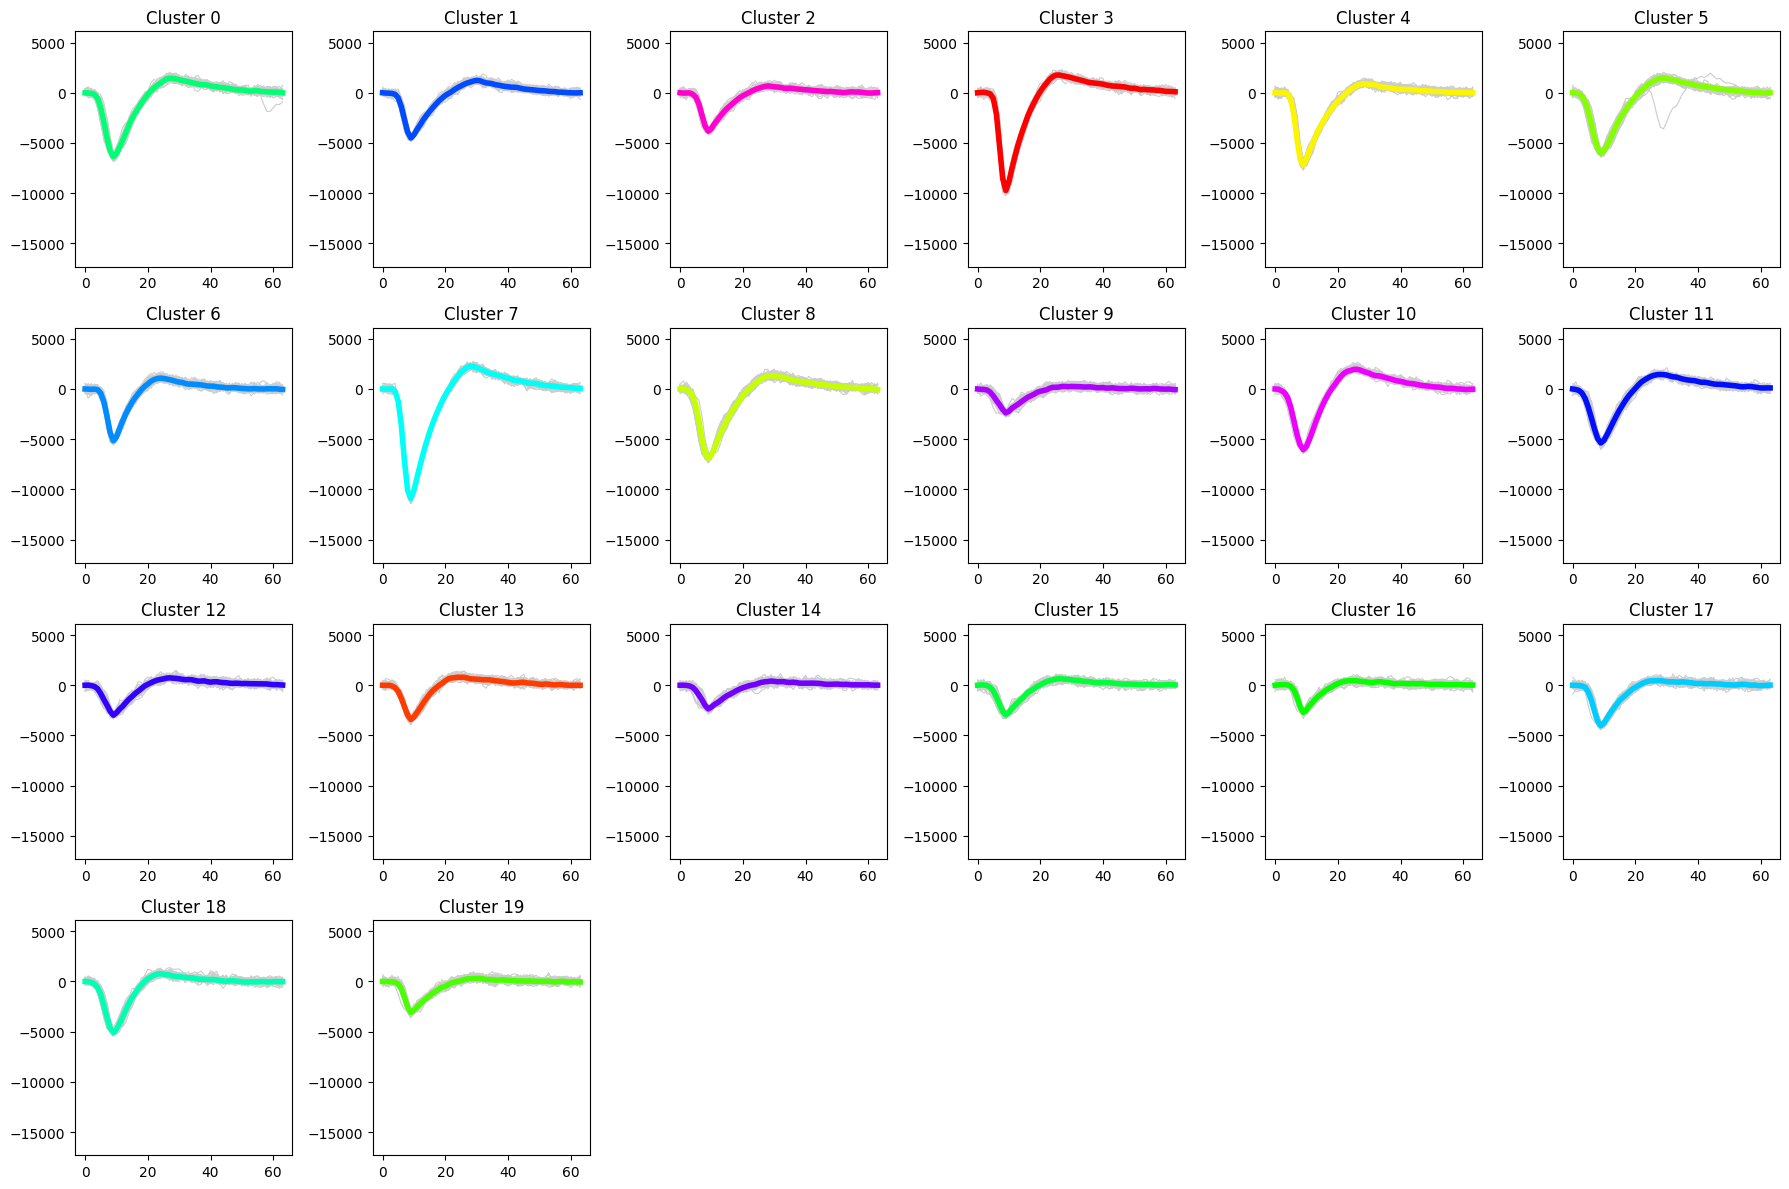

In [8]:
Clusters.PlotShapes(range(20),ncols=6)